In [1]:
import os
from scipy.io import loadmat
import matplotlib.pyplot as plt
from astropy.io import fits
import imageio
import numpy as np
import scipy
from scipy import linalg
import imageio.v2 as imageio
from imageio.core import util as imageio_util
import matplotlib.cm as cm
from psf_functions import *

folder_calibration = '/Volumes/SanDisk/PAPYRUS_run2/02.10.25/Calibration_files_papyrus'
folder_data = '/Volumes/SanDisk/PAPYRUS_run2/02.10.25/record/2025-10-03_00-46-36'
folder_ARPOGE_data = '/Volumes/SanDisk/PAPYRUS_run2/02.10.25/ARPOGE/data'

%matplotlib inline

# Calibration

## Valid pixels mask

valid_pix_mask shape: (128, 160)
valid pixels: 3152


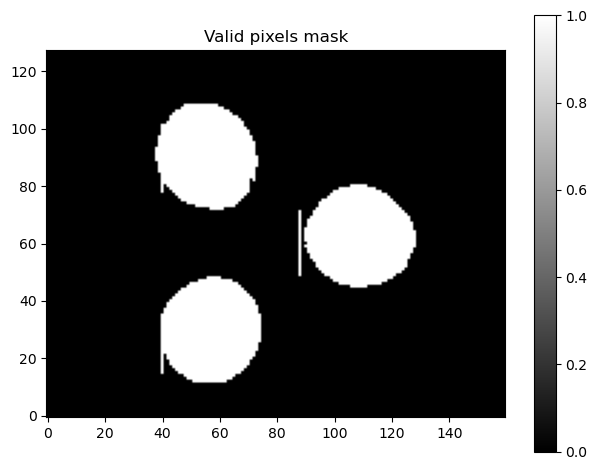

In [2]:
# Load mask
mask_path = os.path.join(folder_calibration, 'mask_3s_pyr.fits')
with fits.open(mask_path) as hdul:
    mask = hdul[0].data

print("valid_pix_mask shape:", mask.shape)

valid_pixels_indices = np.where(mask > 0)
npix_valid = valid_pixels_indices[0].shape[0]
print("valid pixels:", npix_valid)

# Save a visualization (PNG)
plt.figure()
plt.title('Valid pixels mask')
plt.imshow(mask, cmap='gray', origin='lower')
plt.colorbar()
plt.tight_layout()
mask_png = os.path.join(folder_data, 'valid_pixels_mask.png')
plt.savefig(mask_png, dpi=300)
plt.show()

## Reference Image

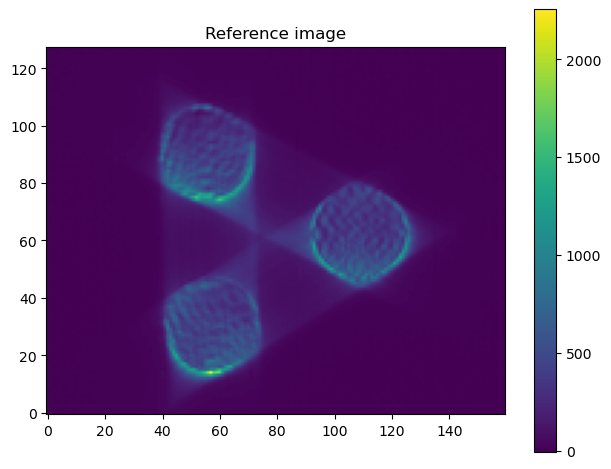

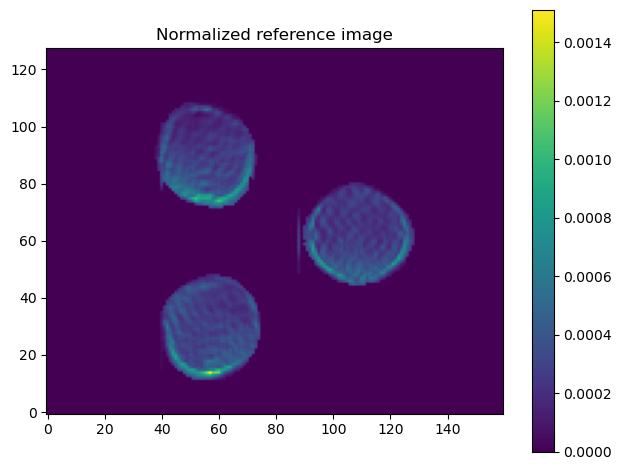

Saved plots:
- /Volumes/SanDisk/PAPYRUS_run2/02.10.25/record/2025-10-03_00-46-36/reference_image.png
- /Volumes/SanDisk/PAPYRUS_run2/02.10.25/record/2025-10-03_00-46-36/normalized_reference_image.png


In [3]:
# Paths
ref_path = os.path.join(folder_calibration, 'reference_image_raw.fits')
#bias_path = os.path.join(folder_calibration, 'bias_image.fits')

reference_image = fits.getdata(ref_path).astype(np.float32)

# --- Save refrence image ---
plt.figure()
plt.title('Reference image')
plt.imshow(reference_image, origin='lower')
plt.colorbar()
plt.tight_layout()
ref_png = os.path.join(folder_data, 'reference_image.png')
plt.savefig(ref_png, dpi=300)
plt.show()

# Normalized reference image
ref_norm_path = os.path.join(folder_ARPOGE_data, 'reference_image_normalized.fits')
normalized_reference_image = fits.getdata(ref_norm_path).astype(np.float32)

# --- Save normalized image plot ---
plt.figure()
plt.title('Normalized reference image')
plt.imshow(normalized_reference_image, origin='lower')
plt.colorbar()
plt.tight_layout()
norm_png = os.path.join(folder_data, 'normalized_reference_image.png')
plt.savefig(norm_png, dpi=300)
plt.show()

print(f"Saved plots:\n- {ref_png}\n- {norm_png}")


## KL2C matrix

KL2C shape: (241, 195)


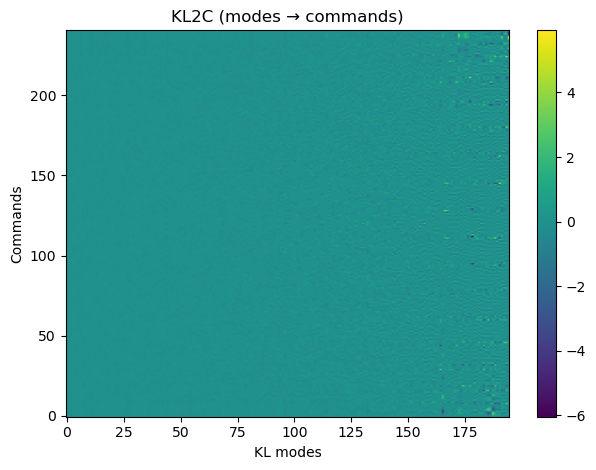

C2KL shape: (195, 241)


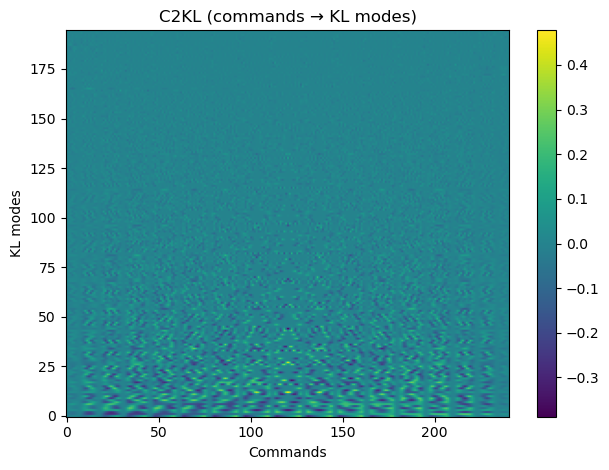

In [4]:
# Load KL2C (aka M2V) from FITS
kl2c_path = os.path.join(folder_data, 'M2V.fits')
KL2C = fits.getdata(kl2c_path).astype(np.float64)

print("KL2C shape:", KL2C.shape)

plt.figure()
plt.imshow(KL2C, aspect='auto', origin='lower')
plt.colorbar()
plt.title('KL2C (modes → commands)')
plt.xlabel('KL modes')
plt.ylabel('Commands')
plt.tight_layout()
plt.show()

# Unit scale for DM
DM_unit = 7.591  # µm

# Pseudoinverse: Commands → KL modes
C2KL = linalg.pinv(KL2C)           # base pseudoinverse
# C2KL = linalg.pinv(KL2C) * DM_unit  # µm-scaled mapping

print("C2KL shape:", C2KL.shape)

plt.figure()
plt.imshow(C2KL, aspect='auto', origin='lower')
plt.colorbar()
plt.title('C2KL (commands → KL modes)')
plt.xlabel('Commands')
plt.ylabel('KL modes')
plt.tight_layout()
plt.show()


## Push-Pull Cube

Cube shape: (195, 128, 160) dtype: >f4


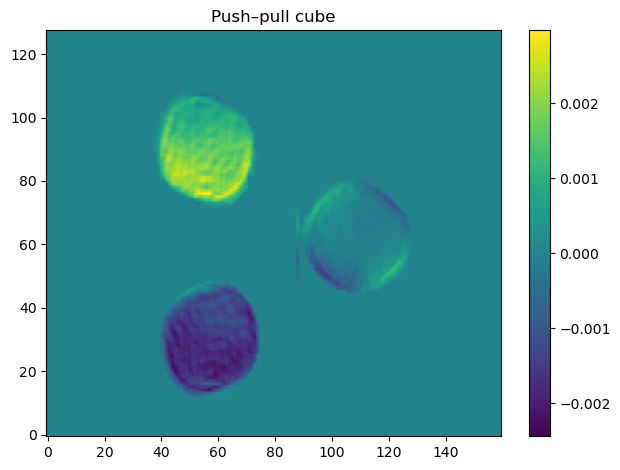

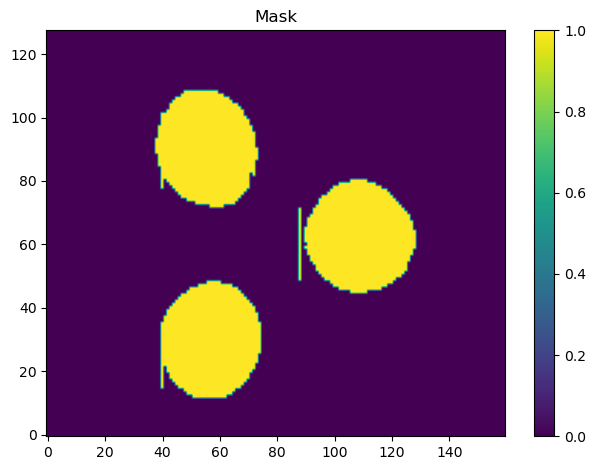

'\n# --- Fix colorbar range across all frames ---\nvmin = - 0.008 #float(np.nanmin(cube))\nvmax = 0.008 #float(np.nanmax(cube))\n\n# --- Render each frame with fixed colorbar and collect RGB images ---\nframes_rgb = []\nfor i in range(cube.shape[0]):\n    fig, ax = plt.subplots(figsize=(6, 4), dpi=150)\n    im = ax.imshow(cube[i], origin=\'lower\', aspect=\'auto\', vmin=vmin, vmax=vmax)\n    cbar = fig.colorbar(im, ax=ax)\n    ax.set_title(f\'Push–pull frame {i}\')\n    fig.tight_layout()\n\n    fig.canvas.draw()\n    w, h = fig.canvas.get_width_height()\n    rgb = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8).reshape(h, w, 3)\n    frames_rgb.append(rgb)\n    plt.close(fig)\n\n# --- Save GIF from RGB frames (no warnings about float→uint8) ---\ngif_path = os.path.join(\'AObench/outputs/Calibration_files_papyrus_best/\', \'push_pull_images.gif\')\nfps = 8\nimageio.mimsave(gif_path, frames_rgb, duration=1.0 / fps, loop=0)\nprint(f"Saved GIF: {gif_path}")\n'

In [5]:
#Push-Pull images
cube_path = os.path.join(folder_calibration, 'processed_response_cube_KL2PWFS_push-pull_nact_17_amp_0.05_3s_pyr.fits')

cube = fits.getdata(cube_path, memmap=True)
print("Cube shape:", cube.shape, "dtype:", cube.dtype)

mask_new = np.zeros_like(cube[0,:,:])
mask_new[cube[0,:,:]!=0] = 1

%matplotlib inline
plt.figure()
plt.title('Push–pull cube')
plt.imshow(cube[0,:,:] , origin='lower', aspect='auto')
plt.colorbar()
plt.tight_layout()
plt.show()


# figure
plt.figure()
plt.title('Mask')
plt.imshow(mask, origin='lower', aspect='auto')
plt.colorbar()
plt.tight_layout()
plt.savefig(os.path.join(folder_calibration,"mask.png"), dpi=300)
plt.show()



"""
# --- Fix colorbar range across all frames ---
vmin = - 0.008 #float(np.nanmin(cube))
vmax = 0.008 #float(np.nanmax(cube))

# --- Render each frame with fixed colorbar and collect RGB images ---
frames_rgb = []
for i in range(cube.shape[0]):
    fig, ax = plt.subplots(figsize=(6, 4), dpi=150)
    im = ax.imshow(cube[i], origin='lower', aspect='auto', vmin=vmin, vmax=vmax)
    cbar = fig.colorbar(im, ax=ax)
    ax.set_title(f'Push–pull frame {i}')
    fig.tight_layout()

    fig.canvas.draw()
    w, h = fig.canvas.get_width_height()
    rgb = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8).reshape(h, w, 3)
    frames_rgb.append(rgb)
    plt.close(fig)

# --- Save GIF from RGB frames (no warnings about float→uint8) ---
gif_path = os.path.join('AObench/outputs/Calibration_files_papyrus_best/', 'push_pull_images.gif')
fps = 8
imageio.mimsave(gif_path, frames_rgb, duration=1.0 / fps, loop=0)
print(f"Saved GIF: {gif_path}")
"""

## Intreaction Matrix

KL2S shape: (195, 3152)


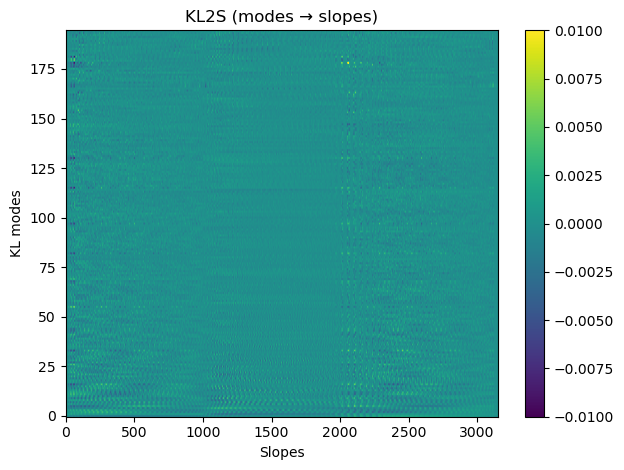

Shape of the reconstruction matrix: (195, 3152)


In [6]:
kl2s_3D_path = os.path.join(folder_calibration, 'processed_response_cube_KL2PWFS_push-pull_nact_17_amp_0.05_3s_pyr.fits')
KL2S_3D = fits.getdata(kl2s_3D_path)

imkl2s_path = os.path.join(folder_calibration, 'response_matrix_KL2S_filtered_nact_17_amp_0.05_3s_pyr.fits')
IM_KL2S = fits.getdata(imkl2s_path)
print("KL2S shape:", IM_KL2S.shape)

plt.figure()
plt.imshow(IM_KL2S, vmax=0.01, vmin=-0.01, aspect='auto', origin='lower')
plt.colorbar()
plt.title('KL2S (modes → slopes)')
plt.xlabel('Slopes')
plt.ylabel('KL modes')
plt.tight_layout()
plt.savefig(os.path.join(folder_data,"IM_KL2S.png"), dpi=300)
plt.show()

"""
IM_KL2S[IM_KL2S==0] = 1
IM_KL2S[IM_KL2S<1] = 0
plt.figure()
plt.imshow(IM_KL2S, aspect='auto', origin='lower')
plt.colorbar()
plt.title('KL2S (modes → slopes)')
plt.xlabel('Slopes')
plt.ylabel('KL modes')
plt.tight_layout()
plt.savefig(os.path.join('AObench/outputs/Calibration_files_papyrus_best',"IM_KL2S_with_zeros.png"), dpi=300)
plt.show()
"""

rms2kl_path = os.path.join(folder_ARPOGE_data, 'RM_S2KL.fits')
RM_S2KL = fits.getdata(rms2kl_path)
print(f"Shape of the reconstruction matrix: {RM_S2KL.shape}")

# Data

## PSF

psf size (512, 640)
psf max 1197066.5087590402
psf center: 74 105
psf com: 86.50802737586022 102.32154862103525
EE: 0.27613398872107253


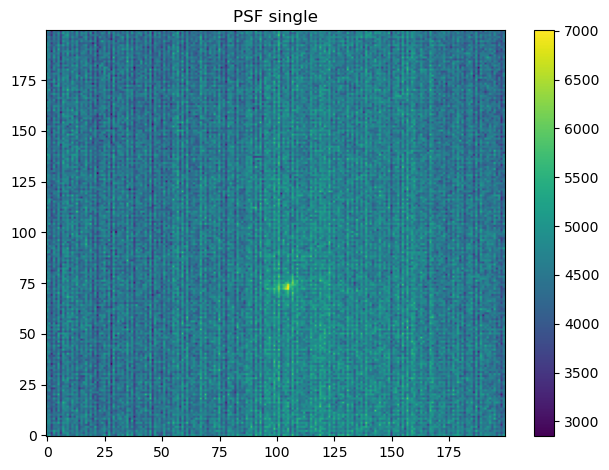

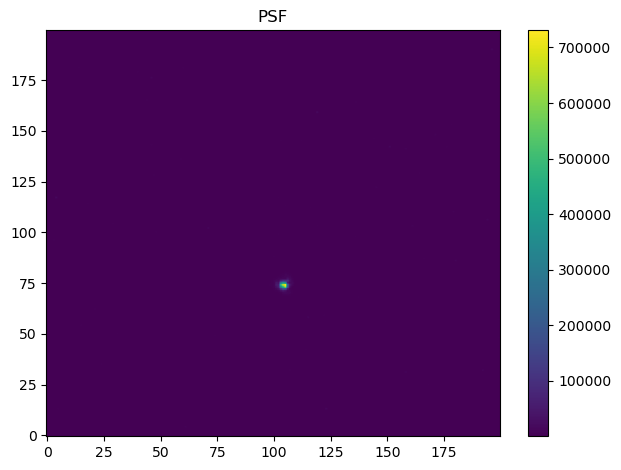

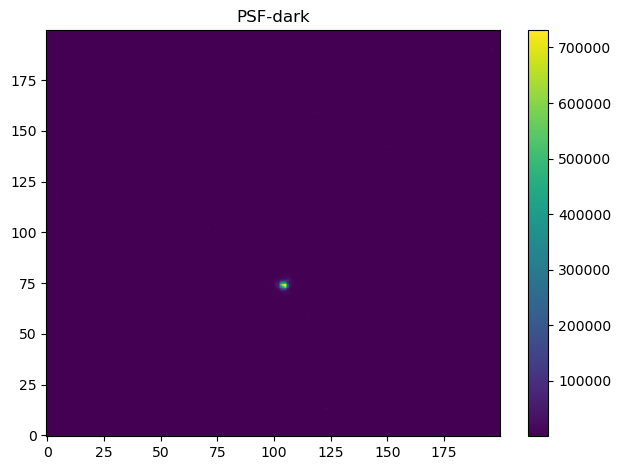

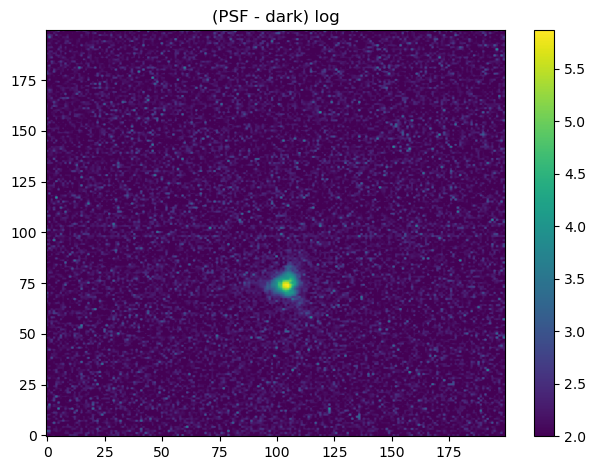

In [16]:
psf_data = fits.getdata(os.path.join(folder_data, 'cred2.fits'))

psf_avg = np.var(psf_data, axis =0)
psf = psf_avg
print("psf size", psf.shape)
print("psf max", psf.max())
psf = psf[200:400, 225:425]

dark = psf[0:50, :]
dark_row = np.var(dark, axis=0)[None, :] 

psf_dark_subs = psf
psf_dark_subs = np.nan_to_num(psf_dark_subs, nan=0.0)
psf_dark_subs[psf_dark_subs < 0] = 0.0 

total_flux = psf_dark_subs.sum()
psf_dark_subs = psf_dark_subs / total_flux

y_peak, x_peak = np.unravel_index(np.argmax(psf_dark_subs), psf_dark_subs.shape)
print('psf center:', y_peak, x_peak)

y_com, x_com = center_of_mass(psf_dark_subs)
print("psf com:", y_com, x_com)

ee_core = encircled_energy_in_3x3(psf_dark_subs, x_peak, y_peak)
print('EE:', ee_core)

plt.figure()
plt.imshow(psf_data[0][200:400, 225:425], aspect='auto', origin='lower')
plt.colorbar()
plt.title('PSF single')
plt.tight_layout()
plt.savefig(os.path.join(folder_data,"PSF.png"), dpi=300)
plt.show()

plt.figure()
plt.imshow(psf, aspect='auto', origin='lower')
plt.colorbar()
plt.title('PSF')
plt.tight_layout()
plt.savefig(os.path.join(folder_data,"PSF.png"), dpi=300)
plt.show()

plt.figure()
plt.imshow(psf, aspect='auto', origin='lower')
plt.colorbar()
plt.title('PSF-dark')
plt.tight_layout()
plt.savefig(os.path.join(folder_data,"PSF.png"), dpi=300)
plt.show()

plt.figure()
plt.imshow(np.log10(psf), vmin=2, aspect='auto', origin='lower')
plt.colorbar()
plt.title('(PSF - dark) log')
plt.tight_layout()
plt.show()

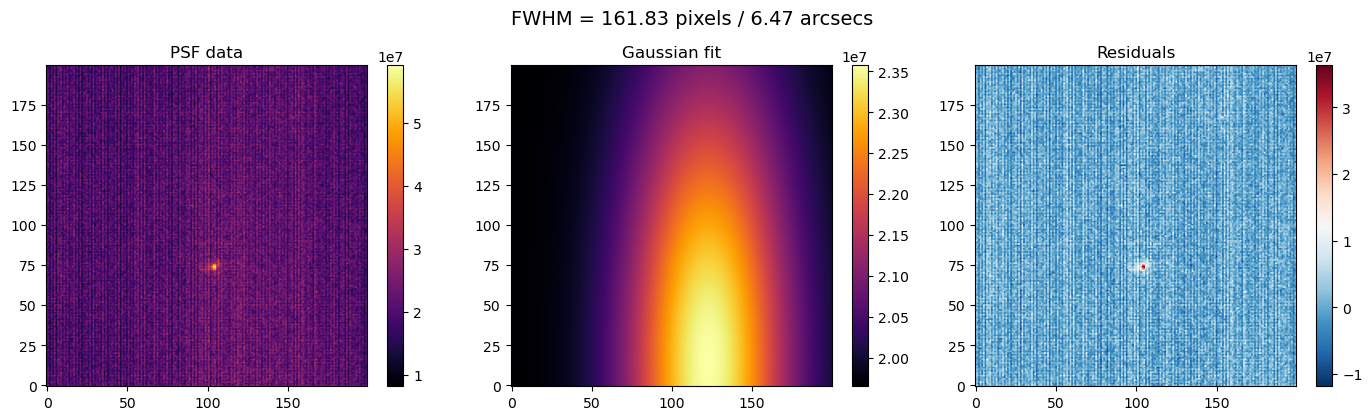

FWHM x: 86.65 pix
FWHM y: 302.21 pix
FWHM geometric mean: 161.83 pix


In [15]:
pixel_scale = 0.04   # arcsec per pixel (example, replace with real value)
psf_sqaured = psf**2
# Fit
(fwhm_x, fwhm_y, fwhm_geom), popt, model = fit_fwhm_2d(psf_sqaured)

# Residuals
residuals = psf_sqaured - model

# Plot
fig, axes = plt.subplots(1, 3, figsize=(14, 4))
im0 = axes[0].imshow(psf_sqaured, origin="lower", cmap="inferno")
axes[0].set_title("PSF data"); plt.colorbar(im0, ax=axes[0])

im1 = axes[1].imshow(model, origin="lower", cmap="inferno")
axes[1].set_title("Gaussian fit"); plt.colorbar(im1, ax=axes[1])

im2 = axes[2].imshow(residuals, origin="lower", cmap="RdBu_r")
axes[2].set_title("Residuals"); plt.colorbar(im2, ax=axes[2])

fig.suptitle(
    f"FWHM = {fwhm_geom:.2f} pixels / {fwhm_geom*pixel_scale:.2f} arcsecs",
    fontsize=14
)

plt.tight_layout()
#plt.savefig(os.path.join('AObench/outputs/Calibration_files_papyrus_best',f"seeing_check_{seeing}arcsecs.png"), dpi=300)
plt.show()

print(f"FWHM x: {fwhm_x:.2f} pix")
print(f"FWHM y: {fwhm_y:.2f} pix")
print(f"FWHM geometric mean: {fwhm_geom:.2f} pix")


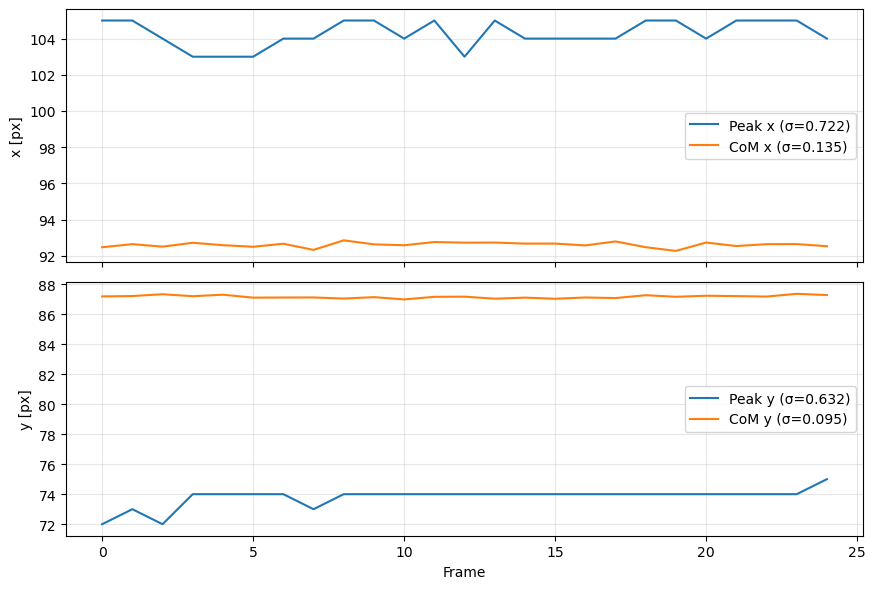

In [9]:
import os
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from scipy.ndimage import center_of_mass

# Load & crop
psf_data = fits.getdata(os.path.join(folder_data, 'cred2.fits'))  # (N, H, W)
ys, ye = 200, 400
xs, xe = 225, 425
N = psf_data.shape[0]

peak_x = np.empty(N); peak_y = np.empty(N)
com_x  = np.empty(N); com_y  = np.empty(N)

for i in range(N):
    img = psf_data[i, ys:ye, xs:xe].astype(float)
    dark_row = np.median(img[:50, :], axis=0, keepdims=True)
    img = img - dark_row
    img[img < 0] = 0.0
    s = img.sum()
    if s <= 0:
        peak_x[i]=peak_y[i]=com_x[i]=com_y[i]=np.nan
        continue
    img /= s

    ypk, xpk = np.unravel_index(np.argmax(img), img.shape)
    ycm, xcm = center_of_mass(img)

    peak_x[i], peak_y[i] = xpk, ypk
    com_x[i],  com_y[i]  = xcm, ycm

# Remove NaNs before computing std
px_std = np.nanstd(peak_x)
py_std = np.nanstd(peak_y)
cx_std = np.nanstd(com_x)
cy_std = np.nanstd(com_y)

t = np.arange(N)

fig, axes = plt.subplots(2, 1, figsize=(9, 6), sharex=True)

axes[0].plot(t, peak_x, label=f'Peak x (σ={px_std:.3f})')
axes[0].plot(t, com_x,  label=f'CoM x (σ={cx_std:.3f})')
axes[0].set_ylabel('x [px]')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(t, peak_y, label=f'Peak y (σ={py_std:.3f})')
axes[1].plot(t, com_y,  label=f'CoM y (σ={cy_std:.3f})')
axes[1].set_xlabel('Frame')
axes[1].set_ylabel('y [px]')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## Frame counters

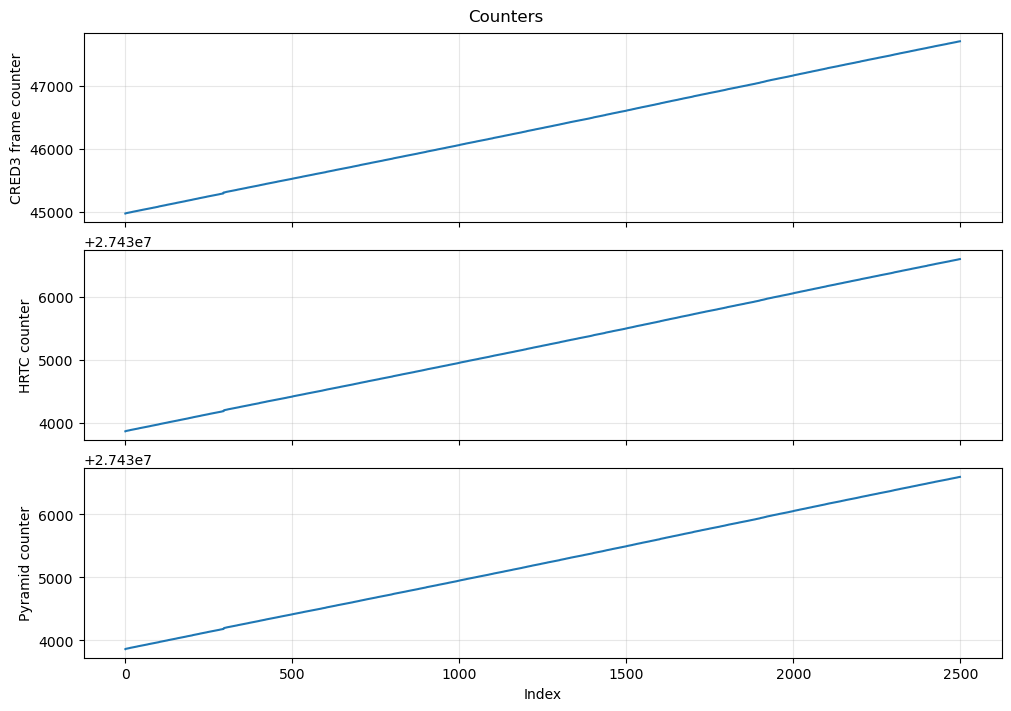

In [10]:
# --- Load data ---
cred3_frame_counter = fits.getdata(os.path.join(folder_data, 'cred3_frame_counter.fits'))
hrtc_counter        = fits.getdata(os.path.join(folder_data, 'hrtc_counter.fits'))
pyramid_counter     = fits.getdata(os.path.join(folder_data, 'pyramid_counter.fits'))


# --- Plot ---
fig, axes = plt.subplots(3, 1, figsize=(10, 7), sharex=True, constrained_layout=True)

axes[0].plot((cred3_frame_counter))
axes[0].set_ylabel("CRED3 frame counter")
axes[0].grid(True, alpha=0.3)
#axes[0].set_ylim(0, 14)

axes[1].plot((hrtc_counter))
axes[1].set_ylabel("HRTC counter")
axes[1].grid(True, alpha=0.3)
#axes[1].set_ylim(0, 14)

axes[2].plot((pyramid_counter))
axes[2].set_ylabel("Pyramid counter")
axes[2].set_xlabel("Index")
axes[2].grid(True, alpha=0.3)
#axes[2].set_ylim(0, 14)

fig.suptitle("Counters")
plt.show()


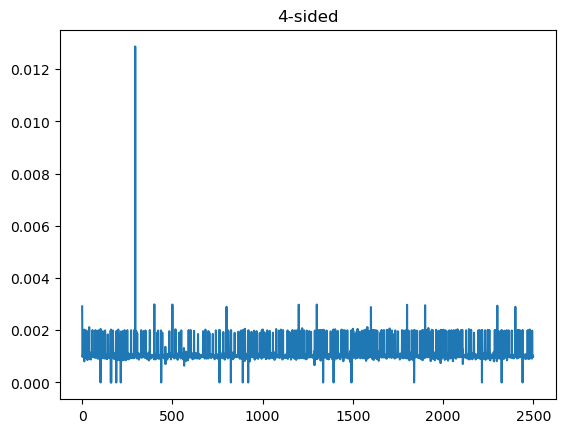

duplicate frames count: 17
missed frames count: 33.4


In [11]:
mode_in_timestamps = fits.getdata(os.path.join(folder_data, 'modes_in_ts.fits'))

mode_in_timestamps_diff = np.diff(np.asarray(mode_in_timestamps.squeeze()))
plt.figure()
plt.plot(mode_in_timestamps_diff)
#plt.ylim(-0.004, 0.014)
plt.title('4-sided')
plt.show()


# Duplicate frames → positions where diff == 0
duplicate_indices = np.where(mode_in_timestamps_diff == 0)[0]

# Missed frames → positions where diff > 0.0015
missed_indices = np.where(mode_in_timestamps_diff > 0.0025)[0]

print("duplicate frames count:", len(duplicate_indices))
#print("duplicate frames positions:", duplicate_indices)

#print("missed frames time:", np.round(mode_in_timestamps_diff[missed_indices], 4) - 0.001)
print("missed frames count:", np.sum(np.round(mode_in_timestamps_diff[missed_indices], 4) - 0.001) / 0.001)
#print("missed frames positions:", missed_indices)


## Modes, Commands, Voltage

modes_in shape: (2500, 195)
modes_out shape: (2500, 195)
voltages shape: (2500, 241)


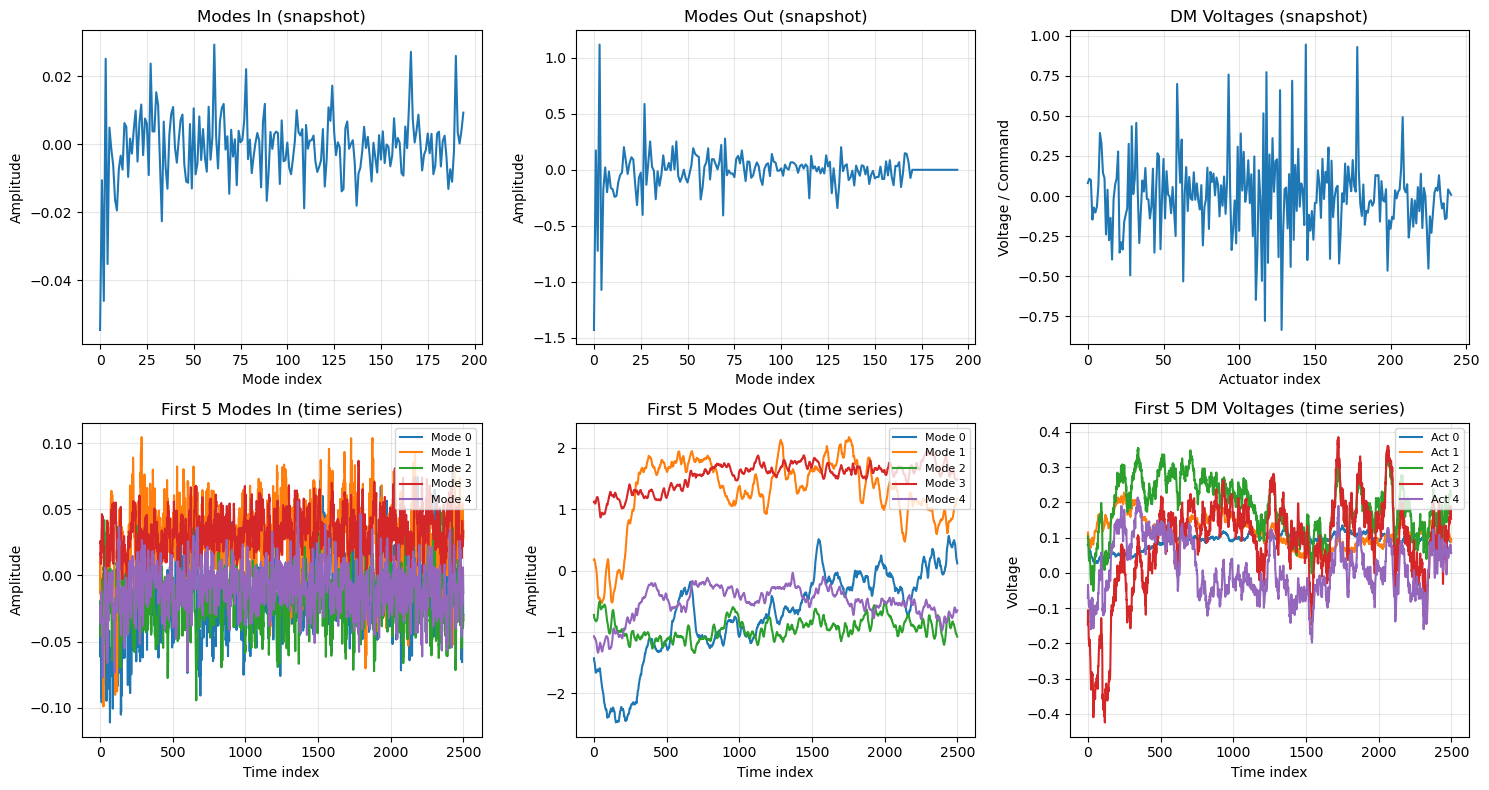

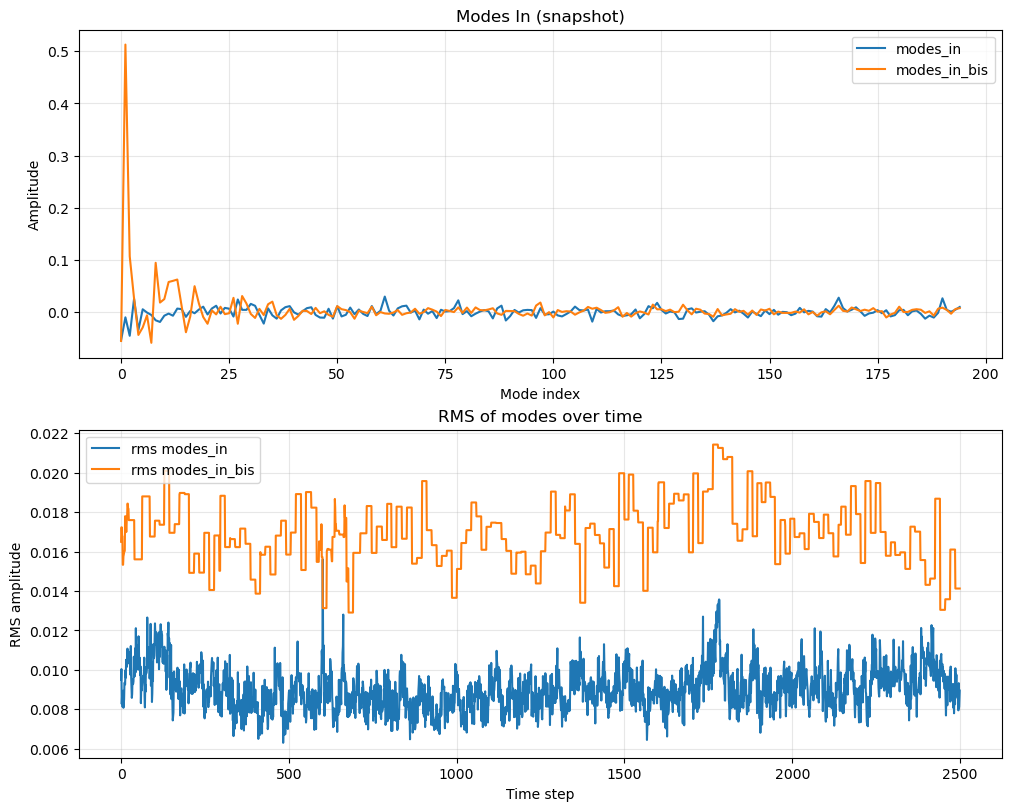

In [12]:
modes_in  = fits.getdata(os.path.join(folder_data, 'modes_in.fits'))
modes_out = fits.getdata(os.path.join(folder_data, 'modes_out.fits'))
voltages  = fits.getdata(os.path.join(folder_data, 'voltages.fits'))
modes_in_bis  = fits.getdata(os.path.join(folder_data, 'modes_in_bis.fits'))


print("modes_in shape:", modes_in.shape)
print("modes_out shape:", modes_out.shape)
print("voltages shape:", voltages.shape)

#tip tilt removed
rms_modes_in = compute_modes_rms(modes_in[:,2:])
rms_modes_in_bis = compute_modes_rms(modes_in_bis[:,2:])

# --- Subplots ---
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.ravel()

snapshot_idx = 0  # time index for snapshot

# Snapshot of all modes in
axes[0].plot(modes_in[snapshot_idx, :], label='modes_in')
axes[0].set_title('Modes In (snapshot)')
axes[0].set_xlabel('Mode index')
axes[0].set_ylabel('Amplitude')
axes[0].grid(True, alpha=0.3)

# Snapshot of all modes out
axes[1].plot(modes_out[snapshot_idx, :])
axes[1].set_title('Modes Out (snapshot)')
axes[1].set_xlabel('Mode index')
axes[1].set_ylabel('Amplitude')
axes[1].grid(True, alpha=0.3)

# Snapshot of DM voltages vector
axes[2].plot(voltages[snapshot_idx, :])
axes[2].set_title('DM Voltages (snapshot)')
axes[2].set_xlabel('Actuator index')
axes[2].set_ylabel('Voltage / Command')
axes[2].grid(True, alpha=0.3)

# First up to 5 modes in over time
for i in range(min(5, modes_in.shape[1])):
    axes[3].plot(modes_in[:, i], label=f'Mode {i}')
axes[3].set_title('First 5 Modes In (time series)')
axes[3].set_xlabel('Time index')
axes[3].set_ylabel('Amplitude')
axes[3].grid(True, alpha=0.3)
axes[3].legend(loc='upper right', fontsize=8)

# First up to 5 modes out over time
for i in range(min(5, modes_out.shape[1])):
    axes[4].plot(modes_out[:, i], label=f'Mode {i}')
axes[4].set_title('First 5 Modes Out (time series)')
axes[4].set_xlabel('Time index')
axes[4].set_ylabel('Amplitude')
axes[4].grid(True, alpha=0.3)
axes[4].legend(loc='upper right', fontsize=8)

# First up to 5 DM voltages over time
for i in range(min(5, voltages.shape[1])):
    axes[5].plot(voltages[:, i], label=f'Act {i}')
axes[5].set_title('First 5 DM Voltages (time series)')
axes[5].set_xlabel('Time index')
axes[5].set_ylabel('Voltage ')
axes[5].grid(True, alpha=0.3)
axes[5].legend(loc='upper right', fontsize=8)

plt.tight_layout()
plt.show()


#comparison 3s and 4s pyr modes
fig, axes = plt.subplots(2, 1, figsize=(10, 8), constrained_layout=True)

axes[0].plot(modes_in[snapshot_idx, :], label='modes_in')
axes[0].plot(modes_in_bis[snapshot_idx, :], label='modes_in_bis')
axes[0].set_title('Modes In (snapshot)')
axes[0].set_xlabel('Mode index')
axes[0].set_ylabel('Amplitude')
axes[0].grid(True, alpha=0.3)
axes[0].legend()

axes[1].plot(rms_modes_in, label='rms modes_in')
axes[1].plot(rms_modes_in_bis, label='rms modes_in_bis')
axes[1].set_title('RMS of modes over time')
axes[1].set_xlabel('Time step')
axes[1].set_ylabel('RMS amplitude')
axes[1].grid(True, alpha=0.3)
axes[1].legend()

plt.show()

## DM channels

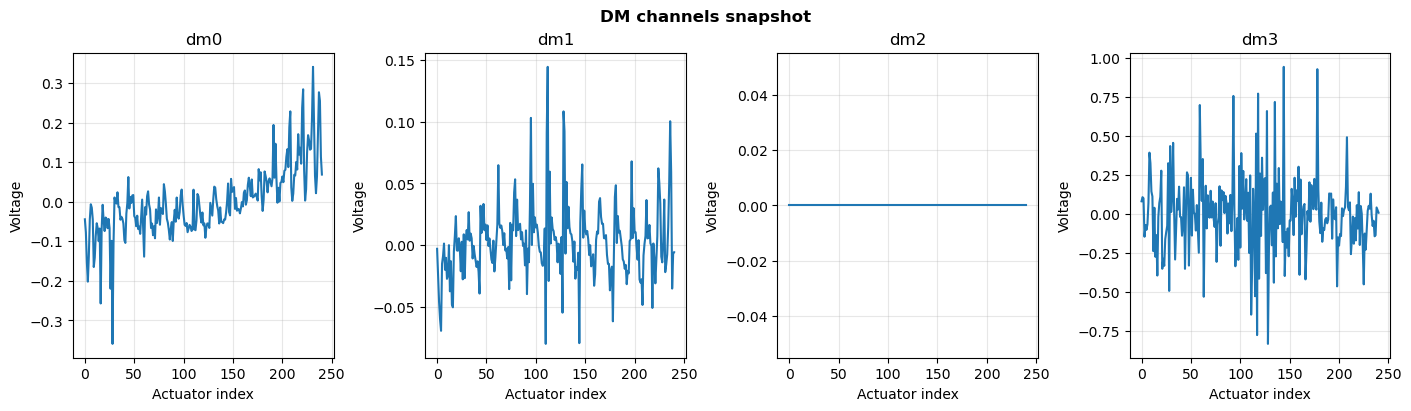

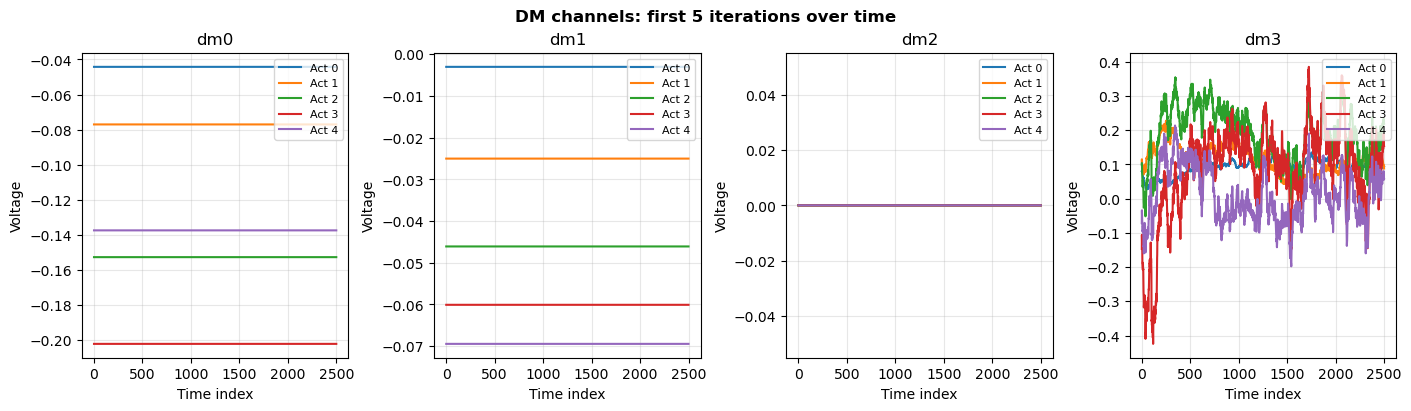

In [13]:
# --- Load 2D DM maps ---
dm0 = fits.getdata(os.path.join(folder_data, 'dm0.fits')).astype(float)
dm1 = fits.getdata(os.path.join(folder_data, 'dm1.fits')).astype(float)
dm2 = fits.getdata(os.path.join(folder_data, 'dm2.fits')).astype(float)
dm3 = fits.getdata(os.path.join(folder_data, 'dm3.fits')).astype(float)

# --- Plot snapshot
fig, axes = plt.subplots(1, 4, figsize=(14, 4), constrained_layout=True)

# Flatten axes so axes[i] is an Axes object
axes = axes.ravel()

# Main title
fig.suptitle("DM channels snapshot", fontsize=12, fontweight="bold")

snapshot_idx = 0  # time index for snapshot

# dm0
axes[0].plot(dm0[snapshot_idx, :])
axes[0].set_title('dm0')
axes[0].set_xlabel('Actuator index')
axes[0].set_ylabel('Voltage')
axes[0].grid(True, alpha=0.3)

# dm1
axes[1].plot(dm1[snapshot_idx, :])
axes[1].set_title('dm1')
axes[1].set_xlabel('Actuator index')
axes[1].set_ylabel('Voltage')
axes[1].grid(True, alpha=0.3)

# dm2
axes[2].plot(dm2[snapshot_idx, :])
axes[2].set_title('dm2')
axes[2].set_xlabel('Actuator index')
axes[2].set_ylabel('Voltage')
axes[2].grid(True, alpha=0.3)

# dm3
axes[3].plot(dm3[snapshot_idx, :])
axes[3].set_title('dm3')
axes[3].set_xlabel('Actuator index')
axes[3].set_ylabel('Voltage')
axes[3].grid(True, alpha=0.3)


# --- Plot over time
fig, axes = plt.subplots(1, 4, figsize=(14, 4), constrained_layout=True)

# Flatten axes so axes[i] is an Axes object
axes = axes.ravel()

# Main title
fig.suptitle("DM channels: first 5 iterations over time", fontsize=12, fontweight="bold")

# Flatten axes for easier 1D indexing
axes = axes.ravel()

# --- dm0 ---
n = 5
for i in range(n):
    axes[0].plot(dm0[:, i], label=f'Act {i}')
axes[0].set_title('dm0')
axes[0].set_xlabel('Time index')
axes[0].set_ylabel('Voltage')
axes[0].grid(True, alpha=0.3)
axes[0].legend(loc='upper right', fontsize=8)

# --- dm1 ---
for i in range(n):
    axes[1].plot(dm1[:, i], label=f'Act {i}')
axes[1].set_title('dm1')
axes[1].set_xlabel('Time index')
axes[1].set_ylabel('Voltage')
axes[1].grid(True, alpha=0.3)
axes[1].legend(loc='upper right', fontsize=8)

# --- dm2 ---
for i in range(n):
    axes[2].plot(dm2[:, i], label=f'Act {i}')
axes[2].set_title('dm2')
axes[2].set_xlabel('Time index')
axes[2].set_ylabel('Voltage')
axes[2].grid(True, alpha=0.3)
axes[2].legend(loc='upper right', fontsize=8)

for i in range(n):
    axes[3].plot(dm3[:, i], label=f'Act {i}')
axes[3].set_title('dm3')
axes[3].set_xlabel('Time index')
axes[3].set_ylabel('Voltage')
axes[3].grid(True, alpha=0.3)
axes[3].legend(loc='upper right', fontsize=8)

plt.show()
